In [10]:
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms


In [11]:
PATH_CIFAR10 = "datasets/cifar-10-batches-py"
PATH_DATABATCH = [f"{PATH_CIFAR10}/data_batch_{i}" for i in range(1, 6)]
PATH_TESTBATCH = f"{PATH_CIFAR10}/test_batch"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tensor(6)


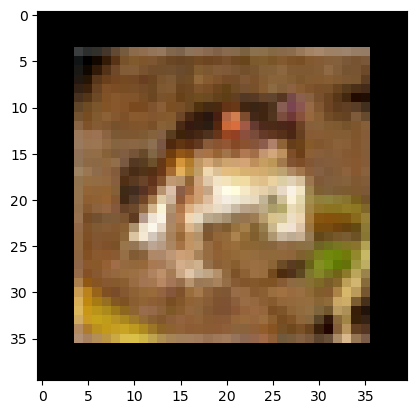

In [17]:
class GPUData:
    def __init__(self):
        self.device = "cuda"
        self.padding = 4
    def cifar10(self):
        # Start by loading the training data
        path_databatch = PATH_DATABATCH
        path_testbatch = PATH_TESTBATCH

        # Deal with the training data
        train_x = []
        train_y = []
        for path in path_databatch:
            with open(path, 'rb') as f:
                dict = pickle.load(f, encoding='bytes')
            train_x.append(dict[b'data'])
            train_y.append(dict[b'labels'])
        train_x = np.concatenate(train_x)
        train_y = np.concatenate(train_y)

        # Deal with the test data
        with open(path_testbatch, 'rb') as f:
            dict = pickle.load(f, encoding='bytes')
        test_x = dict[b'data']
        test_y = dict[b'labels']

        # Establish the transformation)
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))
        ])

        # Convert the data to tensor and normalize it
        train_x = transform(train_x)
        test_x = transform(test_x)

        # Deflatten the data
        train_x = train_x.view(-1, 3, 32, 32)
        test_x = test_x.view(-1, 3, 32, 32)

        # Add padding if necessary
        train_x = torch.nn.functional.pad(
                    train_x, (self.padding, self.padding, self.padding, self.padding))
        test_x = torch.nn.functional.pad(
            test_x, (self.padding, self.padding, self.padding, self.padding))

        # # plot the first image
        # plt.imshow(np.transpose(train_x[0], (1, 2, 0)))
        # print(train_y[0])

        # Flatten the images back to their original shape
        train_x = train_x.view(train_x.shape[0], -1)
        test_x = test_x.view(test_x.shape[0], -1)
        
        train_dataset = GPUTensorDataset(
            train_x, torch.from_numpy(train_y).type(
                torch.LongTensor), device=self.device)
        test_dataset = GPUTensorDataset(test_x.float(), torch.from_numpy(test_y).type(
            torch.LongTensor), device=self.device)
        max_batch_size = len(test_dataset)
        if not self.as_dataset:
            # create a DataLoader to load the data in batches
            train_dataset = GPUDataLoader(
                train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
            test_dataset = GPUDataLoader(
                test_dataset, batch_size=max_batch_size, shuffle=False)
        else:
            # create a DataLoader to load the data in batches
            train_dataset = torch.utils.data.DataLoader(
                train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
            test_dataset = torch.utils.data.DataLoader(
                test_dataset, batch_size=max_batch_size, shuffle=False)
        return train_dataset, test_dataset
g = GPUData()
g.cifar10()
